#### Code for Figure 1 

### - Fig 2: Temperature comparison model vs obs
####        - Same year?
####        - Consider seasonality? Not at the moment, because comparison with seal data would be difficult. 
####        - Start making a map with both / Deep layer? 400m? More?

#### Get Adele's seal code from the vrtual machine. And then have to learn how to load the obs data in as .mat


In [1]:
pwd

'/home/581/ns3783/Scripts/Figures'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45549/status,
Dashboard: /proxy/45549/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37087,Workers: 7
Dashboard: /proxy/45549/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:42175,Total threads: 4
Dashboard: /proxy/39879/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:36617,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: http://sqlalche.me/e/13/e3q8)

### Load temperature data at determined depth

In [ ]:
# load temperature data at 400m:

depth_slice = 400
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22570854512448 and this is thread id 22567920326400.
Exception closing connection <sqlite3.Connection object at 0x1486838966c0>
Traceback (most recent call last):
  File "/g/data/hh5/public/

In [5]:
#average for temperature 
temp_400m_avg = temp_400m.mean('time')

In [6]:
##initially I calculated the model just for 2012, but after having a look on what sort of data the seals had, I decided to do all months from 2004-2018,
## so we would be covering the same period on both
first_year = '2004'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [7]:
# load temperature data at 400m:

depth_slice = 400
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

In [8]:
#just 2012 / this calculates the average for the season, but I no longer want that
#temp_400m_12 = temp_400m.groupby('time.season').mean('time')
#temp_400m_12 = temp_400m_12.loc['MAM',:,:]
temp_400m_12 = temp_400m.mean('time')


In [9]:
temp_400m_12

<xarray.DataArray 'temp' (yt_ocean: 357, xt_ocean: 450)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1.8752851, 1.7590264, 1.6235045, ..., 2.8709393, 2.8721282,
        2.8731303],
       [1.8831215, 1.7673377, 1.6280769, ..., 2.8723164, 2.8730688,
        2.8737733],
       [1.887139 , 1.7667518, 1.6262869, ..., 2.8739889, 2.8743222,
        2.874674 ]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -274.9 -274.8 -274.7 ... -230.2 -230.1 -230.0
  * yt_ocean  (yt_ocean) float64 -75.49 -75.45 -75.41 ... -60.15 -60.1 -60.05
    st_ocean  float64 383.0

### Bathymetry

In [11]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

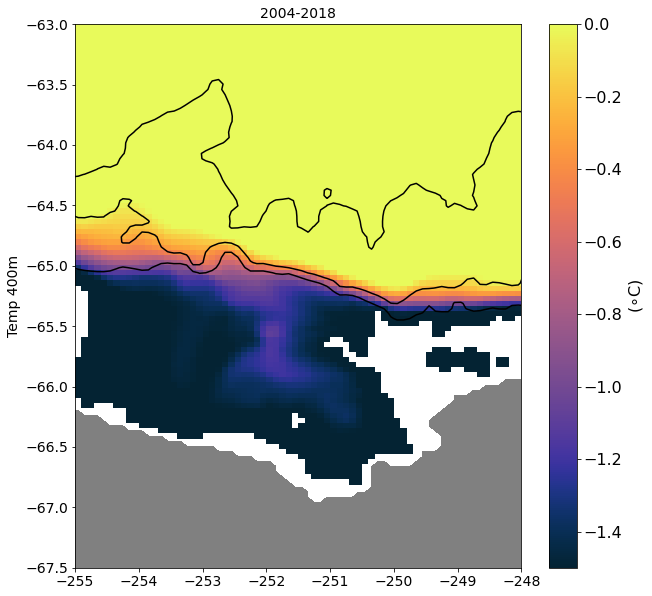

In [12]:
#Prepping variables to plot
fontsize=14

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(temp_400m_12.xt_ocean,temp_400m_12.yt_ocean,
                        temp_400m_12, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
#plt.title('2012 (March-May)',fontsize=fontsize)
plt.title('2004-2018',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=16)

figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/Figure1a_model_2004_2018.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

#### LOAD SEALS 

In [13]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-255, -247)
lat_slice  = slice(-75.5,-60)

In [14]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(control,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

## Get model grid data and temperature climatology:

In [15]:
# for comparing seal data to IAF:
iaf = '01deg_jra55v140_iaf_cycle3'

start_time='2012-01-01'
end_time='2012-12-31'

temp_con = cc.querying.getvar(iaf,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)                          
#temp_con = temp_con.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_con = temp_con[:,:50,:,:]
temp_con = temp_con.load()

In [16]:
xt_ocean = temp_con.xt_ocean
yt_ocean = temp_con.yt_ocean
st_ocean = temp_con.st_ocean

## Select out profiles in correct region:

#### Improvements on this figure: take out winter profiles, sort profiles 
#### Fix it in a way they don't go much shallower than 400m. 

In [17]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/jk72/ns3783/seal_data/'
FileList = glob(path2files+'*.nc')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in West Antarctic Peninsula box:
    WAP_box=lat.where(lon>104).where(lon<114).where(lat<-60).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 20.8 s, sys: 3.31 s, total: 24.1 s
Wall time: 1min 28s


In [18]:
np.shape(WAP_FileList)

(58,)

In [19]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:

nprofiles = 29496 # tested with one run / so this is all good. I know this is the right number for this dataset
ndepth = 1000 #although I have downloaded the profiles with no interpolation, some might have been interpolated because it doesn't run with less than 1000 levels
temp = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
temp_400 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_400 = np.zeros((nprofiles,1))
lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
#date_obs = np.zeros((nprofiles)) 
year_obs = np.zeros((nprofiles))
month_obs = np.zeros((nprofiles))

profile_count = 0

for file in WAP_FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    juld = profile_data.JULD
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        temp_profile = profile_data.TEMP_ADJUSTED[profile]
        if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
            # check the dive reached at least 200 dbar:
            pres_profile = profile_data.PRES_ADJUSTED[profile]
            if pres_profile.max() > 200:
                date = np.append(date,profile_data.JULD[profile])
                #date_obs[profile_count] = date[profile]
                year_obs[profile_count] = profile_data.JULD[profile].dt.year #this is an add on to lock months and years separately
                month_obs[profile_count] = profile_data.JULD[profile].dt.month
                # save profile:
                lat_obs[profile_count] = lat[profile]
                lon_obs[profile_count] = lon[profile]
                # find depth of profile:
                nlevels = len(profile_data.PRES_ADJUSTED[profile])
                temp[profile_count,:nlevels] = temp_profile
                pres[profile_count,:nlevels] = pres_profile
                #save them with the closest number to 400
                array = np.asarray(pres_profile)
                idx = (np.abs(array - 400)).argmin()
                temp_400[profile_count,:] = temp_profile[idx]
                pres_400[profile_count,:] = pres_profile[idx]
                temp[profile_count,:nlevels] = temp_profile
                pres[profile_count,:nlevels] = pres_profile
                profile_count += 1

CPU times: user 2min 22s, sys: 4.31 s, total: 2min 27s
Wall time: 2min 31s


In [20]:
year_obs

array([2015., 2015., 2015., ..., 2019., 2019., 2019.])

### Interpolating the seal data to the model grid. >> this is working know, but I am not sure what exactly I have done that got it right. 

In [21]:
%%time
# Only care about on shelf, so just do top 50 levels:
temp_interp = np.zeros((nprofiles,50))

for profile in range(nprofiles):
    # select out available pressure range of data:
    pres_profile = pres[profile,:][pres[profile,:]>0]
    temp_profile = temp[profile,:][pres[profile,:]>0]
    # also remove missing temperature points:
    temp_profile_adj = temp_profile[temp_profile!=0]
    pres_profile_adj = pres_profile[temp_profile!=0]
    
    f = interpolate.interp1d(pres_profile,temp_profile,bounds_error=False)
    temp_interp[profile,:] = f(st_ocean)

CPU times: user 5.47 s, sys: 172 ms, total: 5.64 s
Wall time: 5.73 s


In [22]:
#

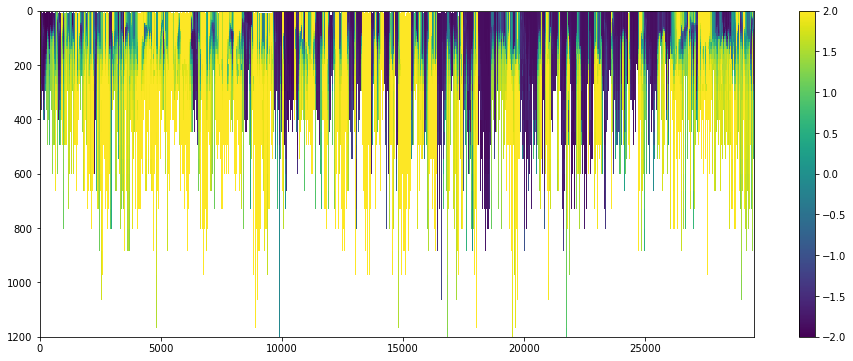

In [23]:
# check profiles look ok:
x_2d,y_2d = np.meshgrid(np.arange(nprofiles),st_ocean)

plt.figure(figsize=(16,6))
plt.pcolormesh(x_2d,y_2d,temp_interp.swapaxes(0,1))
plt.ylim(1200,0)
plt.colorbar()
plt.clim(-2,2)

### saving data

In [25]:
temp_interp = xr.DataArray(temp_interp, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'seal profiles interpolated onto model depth grid')
lon_obs = xr.DataArray(lon_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of seal profiles')
lat_obs = xr.DataArray(lat_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of seal profiles')
month_obs = xr.DataArray(month_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'month of seal profiles')
year_obs = xr.DataArray(year_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'year of seal profiles')
date = xr.DataArray(date, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'date of seal profiles')

ds = xr.Dataset({'temp_interp': temp_interp,'lon_obs':lon_obs,'lat_obs':lat_obs,'month_obs':month_obs,'year_obs':year_obs,'date':date})
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated1.nc'
ds.to_netcdf(outpath)

## Open saved seal data:

In [26]:
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated1.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
month_obs = profile_data.month_obs
year_obs = profile_data.year_obs
temp_interp = profile_data.temp_interp
date = profile_data.date

# need to assign lat/lon coords for binning:
temp_interp = temp_interp.assign_coords({'lon':lon_obs,'lat':lat_obs})

In [27]:
np.unique(year_obs)

array([2004., 2005., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
       2014., 2015., 2016., 2017., 2018., 2019.])

## PLOT

In [28]:
#whos

Text(0.5, 0, 'Longitude')

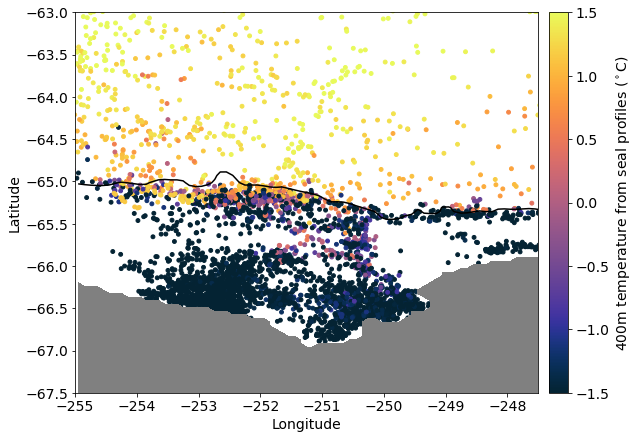

In [29]:
# plot 200m slice:
fontsize = 14
depth_slice = 400

plt.figure(figsize=(10,7))
sc = plt.scatter(lon_obs-360,lat_obs,c=temp_interp.sel(st_ocean=depth_slice,method='nearest'),s=15,cmap=cmocean.thermal,vmin=-1.5,vmax=1.5)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

#figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Bin seal data into lat/lon bins:
### that is because they are a bit on top of one another and my attempt at sortng failed.

In [30]:
# set up new bins:
lon_bins = np.arange(104, 114, .1)
lat_bins = np.arange(-76, -60, .1) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

# just do for a single depth slice:
depth = 400
temp_slice = temp_interp.sel(st_ocean=depth,method='nearest')
# single slice:
binned_meop_temp = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
# full depth:
#binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), coords = [st_ocean,lat_mid, lon_mid], 
#                                dims = ['st_ocean','lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = temp_slice.where(temp_slice.lon <= lon_bins[i+1]).where(temp_slice.lon > lon_bins[i])\
            .where(temp_slice.lat <= lat_bins[j+1]).where(temp_slice.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp[j,i] = (temp_slice * bin_mask).mean(dim = 'profile_number')
        #binned_meop_temp[:,j,i] = (temp_interp * bin_mask).mean(dim = 'profile_number')


lon bin 0/99
lon bin 1/99
lon bin 2/99
lon bin 3/99
lon bin 4/99
lon bin 5/99
lon bin 6/99
lon bin 7/99
lon bin 8/99
lon bin 9/99
lon bin 10/99
lon bin 11/99
lon bin 12/99
lon bin 13/99
lon bin 14/99
lon bin 15/99
lon bin 16/99
lon bin 17/99
lon bin 18/99
lon bin 19/99
lon bin 20/99
lon bin 21/99
lon bin 22/99
lon bin 23/99
lon bin 24/99
lon bin 25/99
lon bin 26/99
lon bin 27/99
lon bin 28/99
lon bin 29/99
lon bin 30/99
lon bin 31/99
lon bin 32/99
lon bin 33/99
lon bin 34/99
lon bin 35/99
lon bin 36/99
lon bin 37/99
lon bin 38/99
lon bin 39/99
lon bin 40/99
lon bin 41/99
lon bin 42/99
lon bin 43/99
lon bin 44/99
lon bin 45/99
lon bin 46/99
lon bin 47/99
lon bin 48/99
lon bin 49/99
lon bin 50/99
lon bin 51/99
lon bin 52/99
lon bin 53/99
lon bin 54/99
lon bin 55/99
lon bin 56/99
lon bin 57/99
lon bin 58/99
lon bin 59/99
lon bin 60/99
lon bin 61/99
lon bin 62/99
lon bin 63/99
lon bin 64/99
lon bin 65/99
lon bin 66/99
lon bin 67/99
lon bin 68/99
lon bin 69/99
lon bin 70/99
lon bin 71/99
lo

In [31]:
 binned_meop_temp.lon_bin

<xarray.DataArray 'lon_bin' (lon_bin: 99)>
array([104.05, 104.15, 104.25, 104.35, 104.45, 104.55, 104.65, 104.75, 104.85,
       104.95, 105.05, 105.15, 105.25, 105.35, 105.45, 105.55, 105.65, 105.75,
       105.85, 105.95, 106.05, 106.15, 106.25, 106.35, 106.45, 106.55, 106.65,
       106.75, 106.85, 106.95, 107.05, 107.15, 107.25, 107.35, 107.45, 107.55,
       107.65, 107.75, 107.85, 107.95, 108.05, 108.15, 108.25, 108.35, 108.45,
       108.55, 108.65, 108.75, 108.85, 108.95, 109.05, 109.15, 109.25, 109.35,
       109.45, 109.55, 109.65, 109.75, 109.85, 109.95, 110.05, 110.15, 110.25,
       110.35, 110.45, 110.55, 110.65, 110.75, 110.85, 110.95, 111.05, 111.15,
       111.25, 111.35, 111.45, 111.55, 111.65, 111.75, 111.85, 111.95, 112.05,
       112.15, 112.25, 112.35, 112.45, 112.55, 112.65, 112.75, 112.85, 112.95,
       113.05, 113.15, 113.25, 113.35, 113.45, 113.55, 113.65, 113.75, 113.85])
Coordinates:
  * lon_bin  (lon_bin) float64 104.0 104.1 104.2 104.3 ... 113.6 113.7 113.8

## PLOT of BINNED TEMP

Text(0.5, 0, 'Longitude')

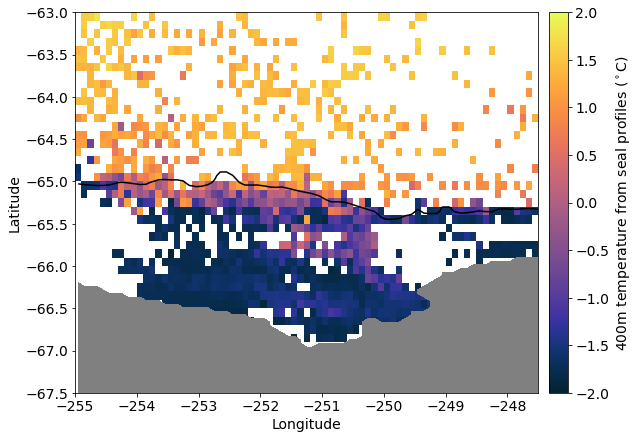

In [32]:
# plot 200m slice:
fontsize = 14
depth_slice = 400

plt.figure(figsize=(10,7))
sc=plt.pcolormesh(binned_meop_temp.lon_bin-360,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

#figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

### Unite both plots

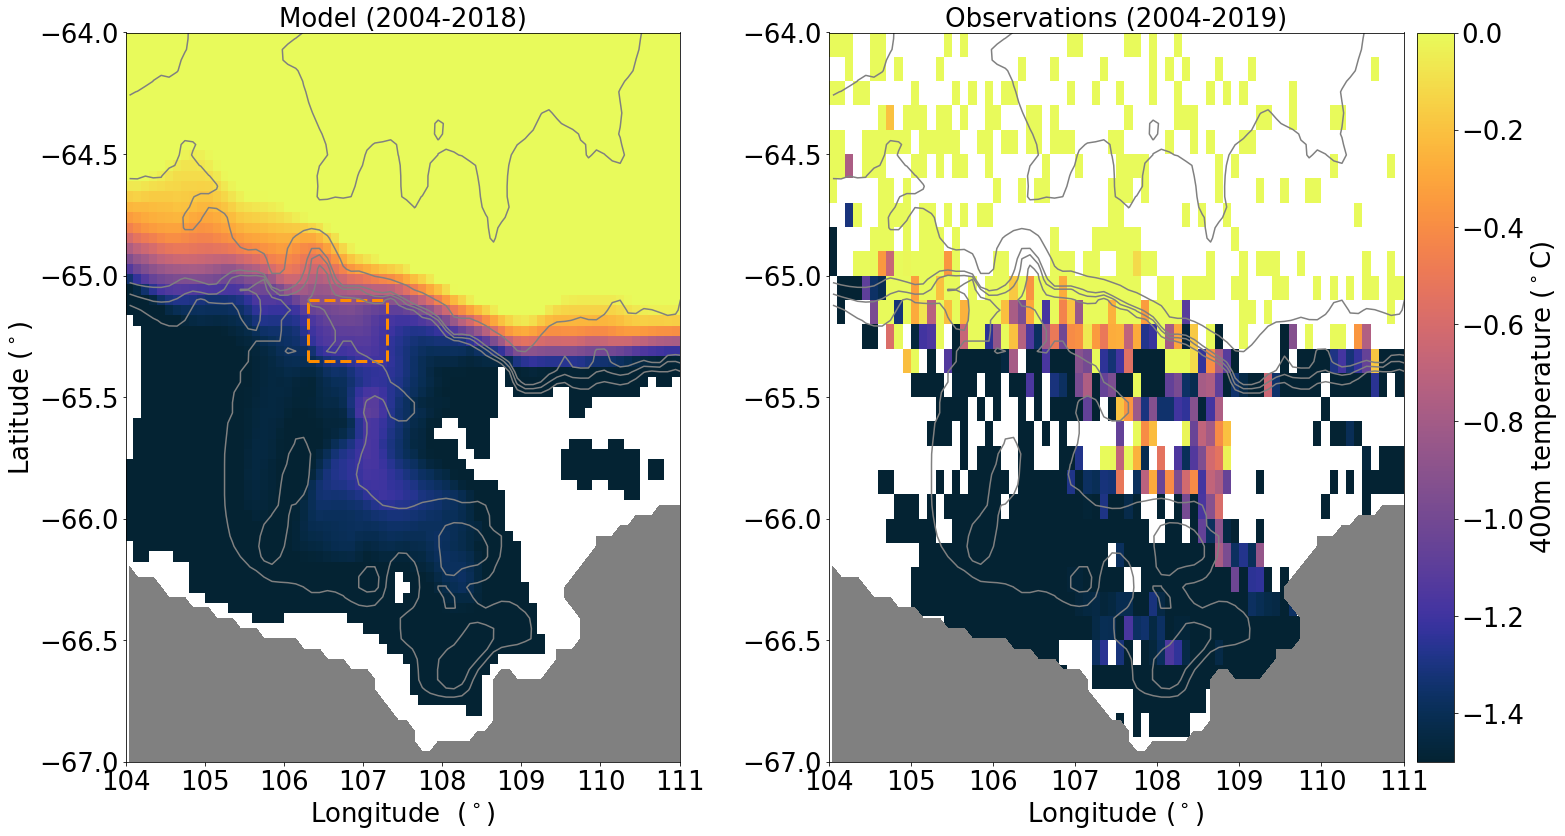

In [40]:
#Prepping variables to plot
fontsize=26

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(temp_400m_12.xt_ocean,temp_400m_12.yt_ocean,
                        temp_400m_12, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax1=plt.subplot(2,2,2)    

sc=plt.pcolormesh(binned_meop_temp.lon_bin-360,binned_meop_temp.lat_bin,binned_meop_temp,cmap=cmocean.thermal,vmin=-1.5,vmax=0)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/Figure1_all_binned.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')